In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My\ Drive/2020_Fall/'Captstone(297)'

/content/drive/My Drive/2020_Fall/Captstone(297)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## House Market Listing

In [4]:
df = pd.read_csv("./data/house_market_listing_property_25025.csv")
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head(2)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (19,54,55,64,65,66,67,68,77,81) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,cc_list_id,original_list_date,original_list_price,current_list_price,sale_price,sale_date,current_status,number_of_pricechanges,days_on_market,hoa_fee_amount,expired_date,cancelled_date,cc_property_id,address,city,zipcode,cc_property_address_county,fips,apn,property_guid,latitude,longitude,sqft,state,lot_sqft,basement_size_sqft,unfinished_basement_size_sqft,year_built,image_urls,geo_point,id,floors_in_property,floors_in_building,garage_spaces,garage_type,pool_spa_types,view_description,porch_or_patio,laundry_features,public_listing_comments,...,full_baths,half_baths,assessed_year,assessed_total_value,tax_amount,land_lease_fee_amount,number_of_parcels,effective_year_built,number_of_units,rooms,basement_type,parking_features,other_parking,current_occupancy_type,heating,cooling,fireplace_count,water_source,image_update_date,property_type,home_style,match_street_address,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,garage_type_enum,cooling_enum,above_grade_bed_count,below_grade_bed_count,below_grade_sqft,current_use,fencing_description,frontage_length,property_condition,property_quality,senior_community_indicator,zoning_code,zoning_description
0,86112818,2017-02-22,629000.0,629000.0,665000.0,2017-07-05,Sale,0.0,21.0,200.0,NaN,NaN,325917590,208 W Springfield St Apt 2,Boston,2118,SUFFOLK,25025,NaN,NaN,42.34034,-71.08054,554.0,MA,554.0,NaN,NaN,1899.0,http://media.mlspin.com/photo.aspx?mls=7212204...,0101000020E610000045813E9127C551C0A5C2D842902B...,4051809.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-04-24,CONDO,Other,208 W SPRINGFIELD ST UNIT 2,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,103942494,2018-03-27,1125000.0,1125000.0,1110000.0,2018-05-21,Sale,0.0,20.0,NaN,NaN,NaN,646971195,10 Brinton St.,Boston,2119,SUFFOLK,25025,5009282,NaN,42.32042,-71.09238,2757.0,MA,4356.0,NaN,NaN,1905.0,NaN,0101000020E61000007DB3CD8DE9C551C0FE7DC6850329...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,TREMENDOUS ROXBURY 2 FAMILY RECENTLY GUT REHAB...,...,3.0,NaN,2017.0,439500.0,4654.0,NaN,NaN,NaN,2.0,13.0,Full Basement,NaN,NaN,NaN,NaN,NaN,NaN,City/Town Water,NaN,MULTI_FAMILY,NaN,10 BRINTON ST,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,res,NaN


### Data Clearning

#### 1. drop na rows and columns

In [5]:
key_columns = ['bedrooms','full_baths']
print("Origin dataset shape: ", df.shape)
dropna_df = df.dropna(subset=key_columns, axis=0, how='any')
print("Dropna dataset shape: ", dropna_df.shape)

Origin dataset shape:  (42438, 81)
Dropna dataset shape:  (24610, 81)


In [7]:
col_names = dropna_df.columns.values
na_pcts = []
n = dropna_df.shape[0]
for col in col_names:
  is_na = sum(dropna_df[col].isna())
  na_pct = 100* is_na/n
  na_pcts.append(na_pct)
  if na_pct<30:
    print(col, " na pct: ", na_pct)
na_pcts = np.array(na_pcts)
print("Columns with less than 30% missing values: ", sum(na_pcts<30))
valid_col_names = col_names[na_pcts<30]
valid_df = dropna_df[valid_col_names]

cc_list_id  na pct:  0.0
original_list_date  na pct:  0.0
current_list_price  na pct:  2.2754977651361235
current_status  na pct:  0.0
days_on_market  na pct:  29.353921170255994
cc_property_id  na pct:  0.0
address  na pct:  0.0
city  na pct:  0.0
zipcode  na pct:  0.0
fips  na pct:  0.0
latitude  na pct:  0.0040633888663145065
longitude  na pct:  0.0040633888663145065
sqft  na pct:  15.335229581470946
state  na pct:  0.0
year_built  na pct:  16.558309630231612
geo_point  na pct:  0.0040633888663145065
bedrooms  na pct:  0.0
full_baths  na pct:  0.0
cooling  na pct:  29.130434782608695
property_type  na pct:  0.0
match_street_address  na pct:  0.0040633888663145065
has_central_air  na pct:  3.6692401462819992
has_jacuzzi  na pct:  3.6692401462819992
has_pool  na pct:  3.6692401462819992
has_solar  na pct:  3.6692401462819992
has_garage  na pct:  3.6692401462819992
Columns with less than 30% missing values:  26


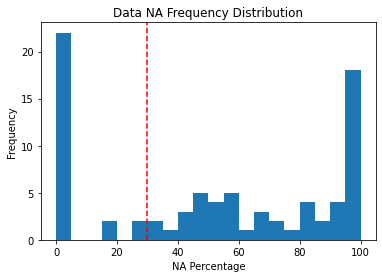

In [8]:
plt.hist(na_pcts, bins=20)
plt.axvline(x=30, c="red", ls="--")
plt.xlabel("NA Percentage")
plt.ylabel("Frequency")
plt.title("Data NA Frequency Distribution")
plt.show()

#### 2. convert categorical features to quantitative features 

duplicate columns
- `geo_point` equal to longitude, latitude info

1.   Exact: 10 Brinton St. ~ longitude, latitude [consider keep one]
2.   Zipcode-level: 02119
3.   City-level: Boston
4.   State-level: MA





In [9]:
duplicate_colums = ['geo_point']
select_valid_df = valid_df.drop(columns=duplicate_colums).copy()
select_valid_df.head(2)

,cc_list_id,original_list_date,current_list_price,current_status,days_on_market,cc_property_id,address,city,zipcode,fips,latitude,longitude,sqft,state,year_built,bedrooms,full_baths,cooling,property_type,match_street_address,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage
1,103942494,2018-03-27,1125000.0,Sale,20.0,646971195,10 Brinton St.,Boston,2119,25025,42.32042,-71.09238,2757.0,MA,1905.0,9.0,3.0,NaN,MULTI_FAMILY,10 BRINTON ST,False,False,False,False,False
22,108020207,2018-08-20,589000.0,Cancelled,23.0,656774586,51-53 Story,Boston,2127,25025,42.33330,-71.04227,722.0,MA,2006.0,2.0,1.0,Central,CONDO,51-53 STORY,True,False,False,False,False


##### 2.1 current_status

In [10]:
select_valid_df.current_status.value_counts()

Sale           8256
Withdrawn      6847
Active         5273
Expired        1937
Cancelled      1101
Pending         912
Pending,        155
Deleted          47
For Rent         44
Foreclosure      37
Other             1
Name: current_status, dtype: int64

In [11]:
# remove sign ","
select_valid_df['current_status'] = select_valid_df['current_status'].apply(lambda x: x.replace(",",""))

# combine 'deleted','for rent', 'foreclosure', 'other' into 'other' category
dic = {'Deleted':'Other', 'For Rent':'Other', 'Foreclosure':'Other'}
select_valid_df['current_status'] = select_valid_df['current_status'].apply(lambda x: dic.get(x, x))

# convert catgorical to numerical 
cat_dic = {'Sale':1, 'Active':2, 'Expired':3,
           'Pending':4,'Other':5, 'Withdrawn':6,'Cancelled':7}
select_valid_df['current_status'] = select_valid_df['current_status'].apply(lambda x: cat_dic.get(x, x))

select_valid_df.current_status.value_counts()

1    8256
6    6847
2    5273
3    1937
7    1101
4    1067
5     129
Name: current_status, dtype: int64

##### 2.2 cooling

In [12]:
select_valid_df.cooling.value_counts()

Central                   12812
None                       1890
Window/Unit                1503
Other                       614
Wall                        506
Refrigeration                47
Central, Other               21
Central, Wall                13
Central, None                 8
Other, Wall                   5
Other, None                   4
Central, Refrigeration        3
Evaporative                   3
Solar                         2
Wall, None                    2
Solar, Wall                   2
Central, Solar                2
Central, Other, Wall          1
Ventilation                   1
Evaporative Cooler            1
Wall, Refrigeration           1
Name: cooling, dtype: int64

In [13]:
# combine 'Solar',into 'Special' category
dic = {'Central, Other':'Central', 'Central, Wall':'Wall', 
       'Other, None':'Other','Central, None':'Central', 'Solar, Wall':'Special',
       'Central, Refrigeration':'Central', 'Other, Wall':'Wall', 
       'Wall, Refrigeration':'Wall', 'Central, Solar':'Special'}
select_valid_df['cooling'] = select_valid_df['cooling'].apply(lambda x: dic.get(x, x))

# one-hot encoding
one_hot_columns = ['is_Central', 'is_Wall', 'is_Window/Unit', 'is_Other', 'is_Special']
one_hot_df = pd.get_dummies(select_valid_df['cooling'], prefix="is")
select_valid_df[one_hot_columns] = one_hot_df[one_hot_columns]

# drop property_type columns
select_valid_df.drop(columns=['cooling'], inplace=True)
select_valid_df.head(2)

,cc_list_id,original_list_date,current_list_price,current_status,days_on_market,cc_property_id,address,city,zipcode,fips,latitude,longitude,sqft,state,year_built,bedrooms,full_baths,property_type,match_street_address,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,is_Central,is_Wall,is_Window/Unit,is_Other,is_Special
1,103942494,2018-03-27,1125000.0,1,20.0,646971195,10 Brinton St.,Boston,2119,25025,42.32042,-71.09238,2757.0,MA,1905.0,9.0,3.0,MULTI_FAMILY,10 BRINTON ST,False,False,False,False,False,0,0,0,0,0
22,108020207,2018-08-20,589000.0,7,23.0,656774586,51-53 Story,Boston,2127,25025,42.33330,-71.04227,722.0,MA,2006.0,2.0,1.0,CONDO,51-53 STORY,True,False,False,False,False,1,0,0,0,0


##### 2.3 property type

In [14]:
print("na ct: ", select_valid_df.property_type.isna().sum())
select_valid_df.property_type.value_counts()

na ct:  0


CONDO           17628
SINGLE           3920
MULTI_FAMILY     2737
OTHER             322
LOT                 3
Name: property_type, dtype: int64

In [15]:
# combine 'LOT',into 'other' category
dic = {'LOT':'OTHER'}
select_valid_df['property_type'] = select_valid_df['property_type'].apply(lambda x: dic.get(x, x))

# one-hot encoding
one_hot_columns = ['is_MULTI_FAMILY', 'is_CONDO', 'is_SINGLE']
one_hot_df = pd.get_dummies(select_valid_df['property_type'], prefix="is")
select_valid_df[one_hot_columns] = one_hot_df[one_hot_columns]

# drop property_type columns
select_valid_df.drop(columns=['property_type'], inplace=True)
select_valid_df.head(2)

,cc_list_id,original_list_date,current_list_price,current_status,days_on_market,cc_property_id,address,city,zipcode,fips,latitude,longitude,sqft,state,year_built,bedrooms,full_baths,match_street_address,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,is_Central,is_Wall,is_Window/Unit,is_Other,is_Special,is_MULTI_FAMILY,is_CONDO,is_SINGLE
1,103942494,2018-03-27,1125000.0,1,20.0,646971195,10 Brinton St.,Boston,2119,25025,42.32042,-71.09238,2757.0,MA,1905.0,9.0,3.0,10 BRINTON ST,False,False,False,False,False,0,0,0,0,0,1,0,0
22,108020207,2018-08-20,589000.0,7,23.0,656774586,51-53 Story,Boston,2127,25025,42.33330,-71.04227,722.0,MA,2006.0,2.0,1.0,51-53 STORY,True,False,False,False,False,1,0,0,0,0,0,1,0


#### 2.4 save csv

In [16]:
select_valid_df.to_csv("./data/cleaned_house_market_listing_property_25025.csv")

### Merge tables

#### merge 4 tables

In [30]:
df_assort = pd.read_csv("./data/assessordata_clean.csv")
df_assort['situsstdfullstreetaddress'] = df_assort['situsstdfullstreetaddress'].str.upper()
exclude_columns = ['Unnamed: 0']
df_assort.drop(columns=exclude_columns, inplace=True)
display(df_assort.head(2))
select_valid_df['address'] = select_valid_df['address'].str.upper()

,formattedapn,situsstdfullstreetaddress,situsstdhousenbr,mailingstdfullstreetaddress,situsstdcity,situsstdzip5,situsstdzip4,situslatitude,situslongitude,propertyclassid,schooldistrictname,lotsizesqft,buildingarea,sumbuildingsqft,sumlivingareasqft,sumgrossareasqft,yearbuilt,effectiveyearbuilt,bedrooms,totalrooms,bathtotalcalc,bathfull,heatcode,garageparkingnbr,storiesnbrcode,stylecode,sumresidentialunits,municipality,assdtotalvalue,assdlandvalue,assdimprovementvalue,taxamount
0,ALLS W:21 P:00418 S:000,74 ASHFORD ST,74,142 HARTMAN RD,ALLSTON,2134.0,1816.0,42.354490,-71.124832,R,Boston School District,4000.0,3986.0,3986.0,3986.0,6167.0,1920.0,2008.0,13.0,19.0,6.0,6.0,10.0,0,300.0,15.0,2,BOSTON-ALLSTON,1494400,321900,1172500,1617473.0
1,ALLS W:21 P:00421 S:000,9 SAWYER TER,9,9 SAWYER TER,ALLSTON,2134.0,1803.0,42.354747,-71.124922,R,Boston School District,3171.0,1763.0,1763.0,1763.0,3158.0,1912.0,1999.0,3.0,6.0,1.5,1.0,10.0,0,200.0,5.0,1,BOSTON-ALLSTON,718500,233600,484900,485169.0


In [32]:
print("Original shape: ", select_valid_df.shape)
merge_df = select_valid_df.merge(df_assort, left_on=['address','zipcode'], 
                                 right_on=['situsstdfullstreetaddress','situsstdzip5'], how='inner')
exclude_columns = ['original_list_date']
merge_df.drop(columns=exclude_columns, inplace=True)
print("New shape: ", merge_df.shape)

Original shape:  (24610, 32)
New shape:  (8378, 63)


In [33]:
merge_df.to_csv('./data/v2_cleaned_master_table_25025.csv', index=False)

### EDA

#### 1. origin vs current price
- very noisy, not used in baseline modeling

No handles with labels found to put in legend.


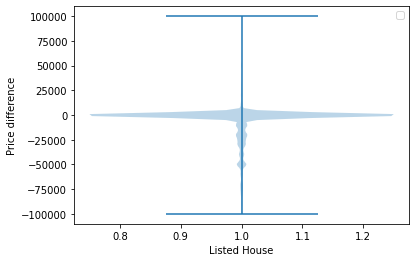

In [18]:
diff_price = df.current_list_price -  df.original_list_price
diff_price.dropna(inplace=True)
diff_price = diff_price[abs(diff_price)<100000]
plt.violinplot(diff_price)
plt.ylabel("Price difference")
plt.xlabel("Listed House")
plt.legend()
plt.show()

/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


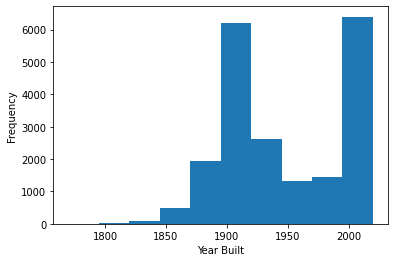

In [19]:
plt.hist(select_valid_df.year_built)
plt.xlabel("Year Built")
plt.ylabel("Frequency")
plt.show()

In [34]:
def help_year_bins(x):
  if x<1900:
    return 'Before 1900'
  elif x<1950:
    return '1900 to 1950'
  elif x<2000:
    return '1950 to 2000'
  else:
    return 'After 2000'

merge_df['year_bins'] = merge_df.year_built.apply(lambda x: help_year_bins(x))

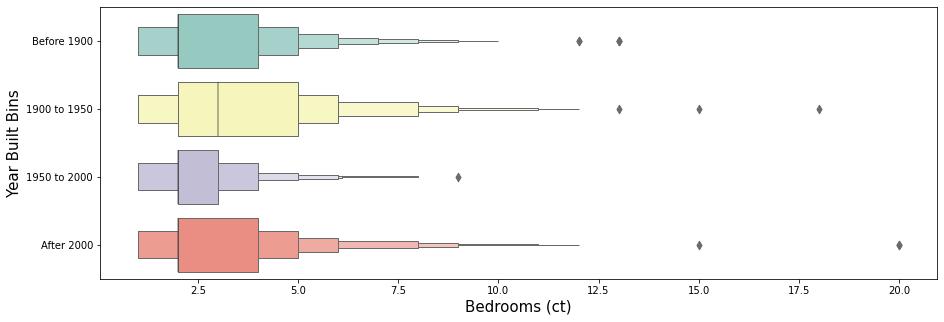

In [35]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxenplot(y='year_bins', x='bedrooms_y', data=merge_df, palette="Set3",
              order=['Before 1900', '1900 to 1950', '1950 to 2000','After 2000'])
plt.xlabel("Bedrooms (ct)", fontsize=15)
plt.ylabel("Year Built Bins", fontsize=15)
plt.show()